# Sparse Hebbian Learning: basics

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.

Here, we will show the basic operations that are implemented in this package. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [2]:
matname = 'basics'

In [3]:
from shl_scripts.shl_experiments import SHL

In [4]:
shl = SHL(verbose=10)
help(shl)

Help on SHL in module shl_scripts.shl_experiments object:

class SHL(builtins.object)
 |  Base class to define SHL experiments:
 |      - initialization
 |      - coding and learning
 |      - visualization
 |      - quantitative analysis
 |  
 |  Methods defined here:
 |  
 |  __init__(self, height=256, width=256, patch_width=21, N_patches=65536, datapath='../database/', name_database='kodakdb', do_mask=True, do_bandpass=True, over_patches=16, patch_ds=1, n_dictionary=529, learning_algorithm='mp', fit_tol=None, do_precision=False, l0_sparseness=29, one_over_F=True, n_iter=1025, eta=0.02, beta1=0.9, beta2=0.999, epsilon=1e-08, homeo_method='HAP', eta_homeo=0.02, alpha_homeo=0.8, C=2.0, nb_quant=64, P_cum=None, do_sym=False, seed=42, patch_norm=False, batch_size=1024, record_each=128, n_image=None, DEBUG_DOWNSCALE=1, verbose=0, data_cache='data_cache')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  code(self, data, dico, coding_algorithm='mp', matname=No

In [5]:
!ls -l {shl.data_cache}/{matname}*

-rw-r--r--  1 laurentperrinet  staff  277280768 Mar 10 20:58 data_cache/basics_coding.npy
-rw-r--r--  1 laurentperrinet  staff  231154688 Mar 10 16:28 data_cache/basics_data.npy
-rw-r--r--  1 laurentperrinet  staff    2978037 Mar 10 20:54 data_cache/basics_dico.pkl


In [6]:
!rm {shl.data_cache}/{matname}*
!ls -l {shl.data_cache}/{matname}*

ls: data_cache/basics*: No such file or directory


In [7]:
data = shl.get_data(matname=matname)
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.sum(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

Extracting data..No cache found data_cache/basics_data: Extracting data... Extracting data..bittern62.png, reflection63.png, yose07.png, rocky10.png, koala52.png, craterlake12.png, clouds43.png, yellowleaves39.png, yose05.png, goldwater67.png, bird08.png, cattails70.png, flowers37.png, woods54.png, cucorn50.png, bora04.png, geyser27.png, flowerhill29.png, calcoast09.png, hibiscus30.png, Data is of shape : (65520, 441) - done in 10.43s.
Data is of shape : (65520, 441) - done in 10.56s.
number of patches, size of patches =  (65520, 441)
average of patches =  6.120844073278042e-05  +/-  0.004903761065625913
average energy of data =  3.9963337815478712 +/- 1.4765442513928164


## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

No cache found data_cache/basics_dico.pkl: Learning the dictionary with algo = mp 
 Training on 65520 patches
Iteration   1 /   1025 (elapsed time:   0s,   0mn   0s)
Iteration  129 /   1025 (elapsed time:  31s,   0mn  31s)
Iteration  257 /   1025 (elapsed time:  62s,   1mn   2s)
Iteration  385 /   1025 (elapsed time:  92s,   1mn  32s)
Iteration  513 /   1025 (elapsed time:  122s,   2mn   2s)
Iteration  641 /   1025 (elapsed time:  153s,   2mn  33s)
Iteration  769 /   1025 (elapsed time:  183s,   3mn   3s)
Iteration  897 /   1025 (elapsed time:  214s,   3mn  34s)
Iteration  1025 /   1025 (elapsed time:  245s,   4mn   5s)
done (total time:  246s,  4.1mn)
done in 246.97s.


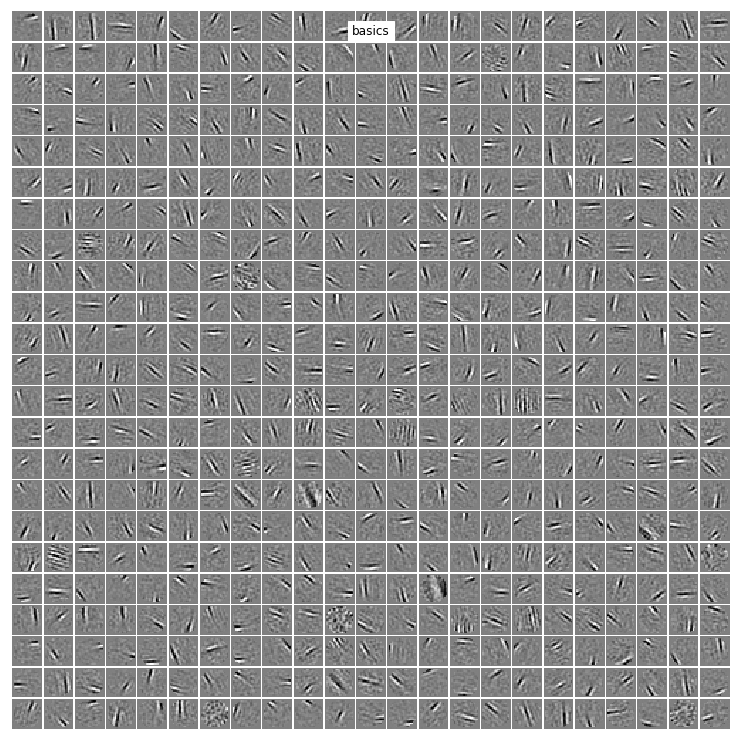

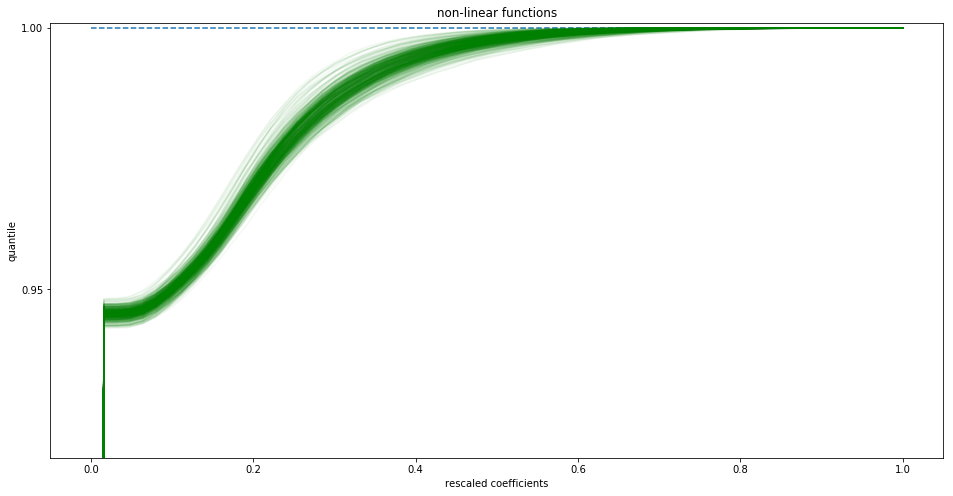

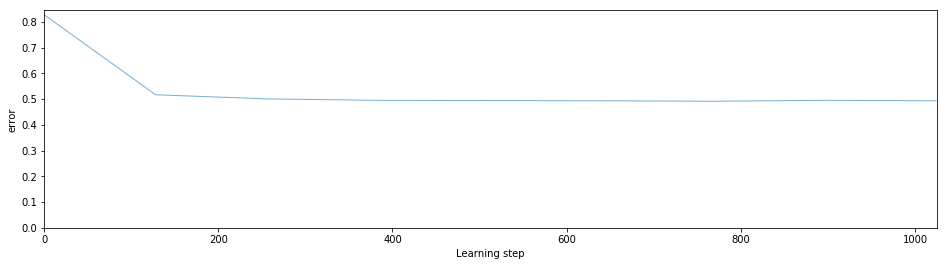

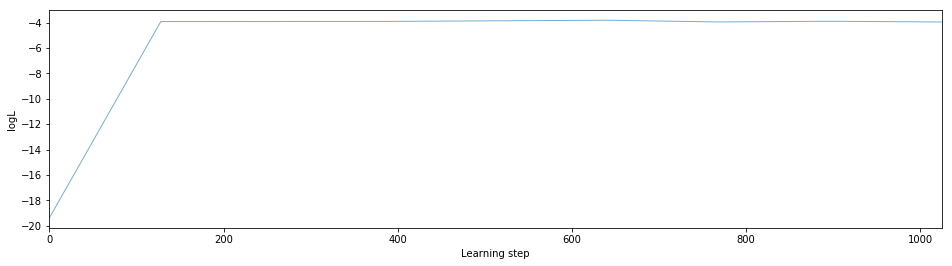

In [8]:
list_figures = ['show_dico', 'time_plot_error', 'time_plot_logL', 'show_Pcum']#, 'plot_variance',  'plot_variance_histogram',  'time_plot_prob',  'time_plot_kurt',  'time_plot_var']
dico = shl.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [9]:
help(dico)

Help on SparseHebbianLearning in module shl_scripts.shl_learn object:

class SparseHebbianLearning(builtins.object)
 |  Sparse Hebbian learning
 |  
 |  Finds a dictionary (a set of atoms) that can best be used to represent data
 |  using a sparse code.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_dictionary : int,
 |      Number of dictionary elements to extract
 |  
 |  eta : float or dict
 |      Gives the learning parameter for the homeostatic gain.
 |  
 |  n_iter : int,
 |      total number of iterations to perform
 |  
 |  eta_homeo : float
 |      Gives the learning parameter for the homeostatic gain.
 |  
 |  alpha_homeo : float
 |      Gives the smoothing exponent  for the homeostatic gain
 |      If equal to 1 the homeostatic learning rule learns a linear relation to
 |      variance.
 |  
 |  dictionary : array of shape (n_dictionary, n_pixels),
 |      initial value of the dictionary for warm restart scenarios
 |      Use ``None`` for a new learning.
 |  
 |  fit_algorith

In [10]:
print('size of dictionary = (number of filters, size of imagelets) = ', dico.dictionary.shape)
print('average of filters = ',  dico.dictionary.mean(axis=1).mean(), 
      '+/-',  dico.dictionary.mean(axis=1).std())
SE = np.sqrt(np.sum(dico.dictionary**2, axis=1))
print('average energy of filters = ', SE.mean(), '+/-', SE.std())

size of dictionary = (number of filters, size of imagelets) =  (529, 441)
average of filters =  1.1916667826032773e-05 +/- 0.0009883411275521648
average energy of filters =  1.0 +/- 8.648382911827316e-17


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

In [11]:
sparse_code = shl.code(data, dico, matname=matname, l0_sparseness=45)
print('number of codes, size of codewords = ', sparse_code.shape)
print('average of codewords = ', sparse_code.mean())
print('average energy of codewords = ', sparse_code.std(axis=0).mean())
print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())

No cache found data_cache/basics_coding.npy: Coding with algo = mp 
 Coding data with algorithm  mp number of codes, size of codewords =  (65520, 529)
average of codewords =  0.03949526335497481
average energy of codewords =  0.1643252680247857
std of the average of individual patches =  0.00530747022823647


In [12]:
patches = sparse_code @ dico.dictionary
print('number of codes, size of reconstructed images = ', patches.shape)

number of codes, size of reconstructed images =  (65520, 441)


In [13]:
error = data - patches
print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
SE = np.sqrt(np.sum(error**2, axis=1))
print('average energy of residual = ', SE.mean(), '+/-', SE.std())

average of residual patches =  -0.00022981587712944595 +/- 0.003653393264350771
average energy of residual =  1.631131956984075 +/- 0.6362859407040758


## Version used

In [14]:
%load_ext version_information
%version_information numpy, shl_scripts

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
IPython 6.2.1
OS Darwin 17.4.0 x86_64 i386 64bit
numpy 1.14.2
shl_scripts 20171221
Wed Mar 21 15:12:11 2018 CET